# <center> <font color='blue'><b>TRANSFER LEARNING - Parte 2 - Fine Tuning</b></font></center>

## Objetivos

Practicarme con Transfer Learning


## Base teórica


Workflow

- Creamos una instancia de un modelo base, con pesos pre-entrenados.
- Congelamos todas las capas en el modelo base configurando trainable=False.
- Creamos un nuevo modelo sobre la salida de una (o más) capas del modelo base.
- Entrenamos los datos con el nuevo dataset.





## Librerías necesarias

In [1]:
# que no se impriman info y warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tensorflow.keras import layers,callbacks,models,Sequential,losses
import seaborn as sns
from sklearn.metrics import confusion_matrix
import keras_tuner
from tensorflow import keras
from keras import backend as K
import os,random
import pandas as pd
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers.experimental import preprocessing



## Helper Functions

In [3]:
# plot history
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
    plt.legend()

    #plt.figure()
    plt.subplot(1,2,2)
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
    plt.legend()
    plt.show()

## Carga de datos

In [4]:
seed_value = 57
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [5]:
IMG_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir='/home/marcos/Escritorio/IA/IA---Study/S6 - Transfer Learning - p1/data/Sports-celebrity images/train'
test_dir='/home/marcos/Escritorio/IA/IA---Study/S6 - Transfer Learning - p1/data/Sports-celebrity images/test'

In [34]:
# Configura el generador de datos con solo preprocess_input
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,validation_split=0.2)


# es de notar que NO ponemos rescaling en ImageDataGenerator pues tf.keras.applications.efficientnet
# ya lo incluye


#
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


#
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMG_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Found 315 images belonging to 4 classes.
Found 78 images belonging to 4 classes.
Found 50 images belonging to 4 classes.


In [88]:
num_classes = train_generator.num_classes
print(num_classes)

4


In [89]:
# Obtiene el diccionario que asigna nombres de clases a sus índices
class_indices = train_generator.class_indices
# Invierte el diccionario para obtener un diccionario que asigna índices a nombres de clases
indices_to_classes = {v: k for k, v in class_indices.items()}
# Imprime los nombres de las clases
class_names = list(indices_to_classes.values())
print("Nombres de las clases:", class_names)

Nombres de las clases: ['Kane Williamson', 'Kobe Bryant', 'Maria Sharapova', 'Ronaldo']


### AHora trabajaremos con un modelo base y le agregaremos capas

EfficentNet + Global Average Pooling + Capa densa de salida (y data augmentation)

In [8]:
# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet's having resclaing built-in
], name="data_augmentation")

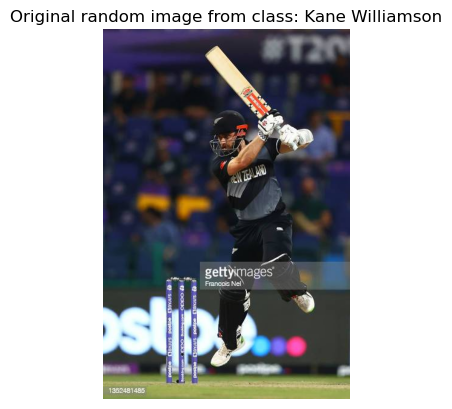

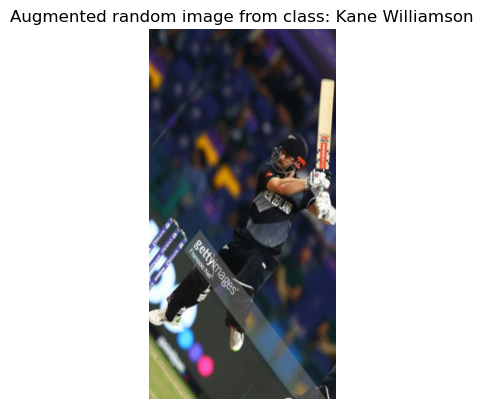

In [93]:
target_class = random.choice(class_names)
target_dir = "data/Sports-celebrity images/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot in the random image 
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);


El modelo base será EfficientNet, en la siguiente celda creamos uno nuevo a partir de él.

In [65]:
input_shape = IMG_SHAPE+(3,)

    
# base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# create inputs into our model
inputs = tf.keras.layers.Input(shape=input_shape,name='input_layer')



# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs,training=True)


# pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# global average pooling
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")


# output
outputs = tf.keras.layers.Dense(num_classes,activation='softmax',name='output_layer')(x)
# comibne the inputs and the outputs into a model
model = tf.keras.Model(inputs,outputs)




Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)


In [66]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 5,124
Non-trainable params: 4,049,571
_________________________________________________________________


In [67]:
# Check the layers in our model
for layer_number, layer in enumerate(model.layers):
  print(layer_number, layer.name)

0 input_layer
1 efficientnetb0
2 global_average_pooling_layer
3 output_layer


In [68]:
# las de efficnet net
for layer in model.layers[1].layers:
    print(layer.name, layer.trainable)

input_6 False
rescaling_10 False
normalization_5 False
rescaling_11 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2

Entrenamos el modelo con los nuevos datos.

In [69]:
# compile
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [70]:
# fit
history = model.fit(train_generator,
                     epochs=10,
                     steps_per_epoch=len(train_generator),
                     validation_data=validation_generator,
                     validation_steps=len(validation_generator))

Epoch 1/10
10/10 [==============================] - 18s 1s/step - loss: 1.3078 - accuracy: 0.4159 - val_loss: 1.0974 - val_accuracy: 0.6282
Epoch 2/10
10/10 [==============================] - 12s 1s/step - loss: 0.9396 - accuracy: 0.7238 - val_loss: 0.8720 - val_accuracy: 0.7436
Epoch 3/10
10/10 [==============================] - 11s 1s/step - loss: 0.7244 - accuracy: 0.8349 - val_loss: 0.7344 - val_accuracy: 0.7692
Epoch 4/10
10/10 [==============================] - 11s 1s/step - loss: 0.5673 - accuracy: 0.8921 - val_loss: 0.6482 - val_accuracy: 0.7692
Epoch 5/10
10/10 [==============================] - 11s 1s/step - loss: 0.4741 - accuracy: 0.9175 - val_loss: 0.5886 - val_accuracy: 0.7821
Epoch 6/10
10/10 [==============================] - 11s 1s/step - loss: 0.4164 - accuracy: 0.9111 - val_loss: 0.5531 - val_accuracy: 0.8077
Epoch 7/10
10/10 [==============================] - 11s 1s/step - loss: 0.3737 - accuracy: 0.9111 - val_loss: 0.5227 - val_accuracy: 0.8205
Epoch 8/10
10/10 [==

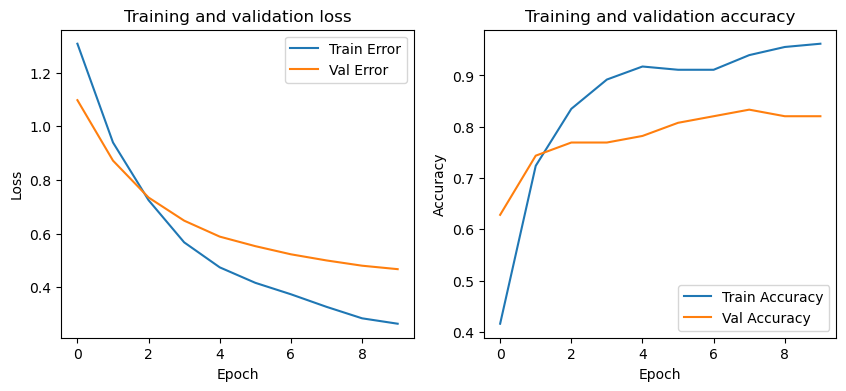

In [71]:
plot_history(history)

Los gráficos parecen mostrar cierta tendencia al overfitting.

In [72]:
scores = model.evaluate(test_generator)

2/2 [==============================] - 2s 523ms/step - loss: 0.4750 - accuracy: 0.8400


## Fine tuning


Una vez que el modelo alcanzó la convergencia con los nuevos datos, puede intentar descongelar todo o parte del modelo base y re-entrenar el modelo con una tasa de aprendizaje muy pequeña.
Esto puede llevar a grandes mejoras pero también a incrementar a un rápido overfitting, téngalo presente.

Es crítico realizar este paso solamente luego de que el modelo con las capas congeladas haya sido entrenado para la convergencia. Si mezcla capas entrenables inicializadas aleatoriamente con capas entrenables que tienen características pre-entrenadas, las inicializadas aleatoriamente provocarán actualizaciones grandes del gradiente durante el entrenamiento, lo que destruirá sus características pre-entrenadas.

También es crítico usar una tasa de aprendizaje muy pequeña en esta etapa, pues está entrenando un modelo mucho más grande que en la primer etapa, sobre un dataset que típicamente es pequeño. Por ello, corre el riesgo de caer rápidamente en el overfitting si aplica grandes actualizaciones de pesos. Aquí sólo quiere readaptar los pesos pre-entrenados de forma incremental.


In [73]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # when fine-tuning you typically want to lower the learning rate by 10x*
                metrics=["accuracy"])



In [75]:

# callbacks

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience = 5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)



# fit
history = model.fit(train_generator,
                     epochs=10,
                     steps_per_epoch=len(train_generator),
                     validation_data=validation_generator,
                     validation_steps=len(validation_generator),
                     callbacks=[early_stopping,reduce_lr])

Epoch 1/10
10/10 [==============================] - 12s 1s/step - loss: 0.3035 - accuracy: 0.9683 - val_loss: 0.4672 - val_accuracy: 0.8462 - lr: 1.0000e-05
Epoch 2/10
10/10 [==============================] - 12s 1s/step - loss: 0.2997 - accuracy: 0.9714 - val_loss: 0.4664 - val_accuracy: 0.8462 - lr: 1.0000e-05
Epoch 3/10
10/10 [==============================] - 12s 1s/step - loss: 0.2945 - accuracy: 0.9714 - val_loss: 0.4656 - val_accuracy: 0.8462 - lr: 1.0000e-05
Epoch 4/10
10/10 [==============================] - 12s 1s/step - loss: 0.2844 - accuracy: 0.9810 - val_loss: 0.4643 - val_accuracy: 0.8462 - lr: 1.0000e-05
Epoch 5/10
10/10 [==============================] - 12s 1s/step - loss: 0.2845 - accuracy: 0.9683 - val_loss: 0.4632 - val_accuracy: 0.8462 - lr: 1.0000e-05
Epoch 6/10
10/10 [==============================] - 12s 1s/step - loss: 0.2645 - accuracy: 0.9841 - val_loss: 0.4618 - val_accuracy: 0.8462 - lr: 1.0000e-05
Epoch 7/10
10/10 [==============================] - 12s 1s

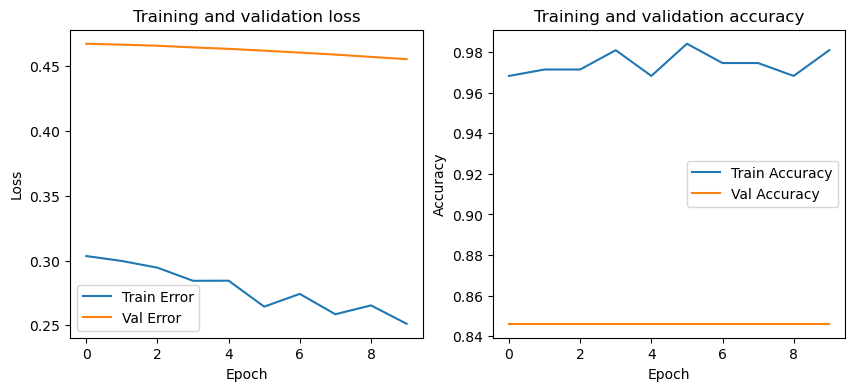

In [76]:
plot_history(history)

Tenemos un claro overfitting, algunas opciones para mejor esta situación son:

- Conseguir más datos.
- Usar un modelo base menos complejo que efficient net.

In [77]:
model.evaluate(test_generator)

2/2 [==============================] - 2s 583ms/step - loss: 0.4275 - accuracy: 0.8800


[0.4275211691856384, 0.8799999952316284]